In [2]:
# Two lines that remove tensorflow GPU logs
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import model_selection
from math import ceil

In [3]:
fer_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

In [5]:
# Loads csv files and appends pixels to X and labels to y
#  preprocess_data():
data = pd.read_csv('fer_data/fer2013.csv')
labels = pd.read_csv('fer_data/fer2013new.csv')

orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                    'unknown', 'NF']

n_samples = len(data)
w = 48
h = 48

y = np.array(labels[orig_class_names])
X = np.zeros((n_samples, w, h, 1))
for i in range(n_samples):
    X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))

In [6]:
# clean_data_and_normalize(X, y):
orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                    'unknown', 'NF']

# Using mask to remove unknown or NF images
y_mask = y.argmax(axis=-1)
mask = y_mask < orig_class_names.index('unknown')
X = X[mask]
y = y[mask]

# Convert to probabilities between 0 and 1
y = y[:, :-2] * 0.1

# Add contempt to neutral and remove it
y[:, 0] += y[:, 7]
y = y[:, :7]

# Normalize image vectors
X = X / 255.0


In [7]:
# split_data(X, y):
test_size = ceil(len(X) * 0.1)

# Split Data
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=42)
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=test_size,
                                                                    random_state=42)

In [8]:
# data_augmentation(x_train):
shift = 0.1
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    height_shift_range=shift,
    width_shift_range=shift)
datagen.fit(x_train)

In [9]:
epochs = 100
batch_size = 64

print("X_train shape: " + str(x_train.shape))
print("Y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(x_test.shape))
print("Y_test shape: " + str(y_test.shape))
print("X_val shape: " + str(x_val.shape))
print("Y_val shape: " + str(y_val.shape))

X_train shape: (28390, 48, 48, 1)
Y_train shape: (28390, 7)
X_test shape: (3549, 48, 48, 1)
Y_test shape: (3549, 7)
X_val shape: (3549, 48, 48, 1)
Y_val shape: (3549, 7)


In [10]:
input_shape=x_train[0].shape
classes=len(fer_classes)    #input_shape=(48, 48, 1), classes=7

num_features = 64

model = Sequential()

# 1st stage
model.add(Conv2D(num_features, kernel_size=(3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))    #rectified liner unit
model.add(Conv2D(num_features, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Dropout(0.5))

# 2nd stage
model.add(Conv2D(num_features, (3, 3), activation='relu'))
model.add(Conv2D(num_features, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 3rd stage
model.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

# 4th stage
model.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
model.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 5th stage
model.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(Flatten())

# Fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(classes, activation='softmax'))

model.summary()
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\assad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 44, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 44, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,623,239 (13.82 MB)

 Trainable params: 3,621,447 (13.81 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [11]:
from keras.callbacks import  ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='auto')

callbacks_list = [early_stop, reduce_lr]

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                    steps_per_epoch=len(x_train) // batch_size,
                    validation_data=(x_val, y_val), verbose=2,
                    callbacks=callbacks_list
                    )

test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)

Epoch 1/100


c:\Users\assad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


443/443 - 363s - 819ms/step - accuracy: 0.4127 - loss: 0.3450 - val_accuracy: 0.3801 - val_loss: 0.3978 - learning_rate: 1.0000e-04
Epoch 2/100


c:\Users\assad\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


443/443 - 10s - 23ms/step - accuracy: 0.5156 - loss: 0.3352 - val_accuracy: 0.3801 - val_loss: 0.3985 - learning_rate: 1.0000e-04
Epoch 3/100
443/443 - 336s - 759ms/step - accuracy: 0.5447 - loss: 0.3050 - val_accuracy: 0.5754 - val_loss: 0.2968 - learning_rate: 1.0000e-04
Epoch 4/100
443/443 - 11s - 25ms/step - accuracy: 0.6875 - loss: 0.2713 - val_accuracy: 0.5740 - val_loss: 0.2970 - learning_rate: 1.0000e-04
Epoch 5/100
443/443 - 339s - 766ms/step - accuracy: 0.6057 - loss: 0.2811 - val_accuracy: 0.6748 - val_loss: 0.2563 - learning_rate: 1.0000e-04
Epoch 6/100
443/443 - 9s - 21ms/step - accuracy: 0.6406 - loss: 0.2680 - val_accuracy: 0.6726 - val_loss: 0.2563 - learning_rate: 1.0000e-04
Epoch 7/100
443/443 - 326s - 737ms/step - accuracy: 0.6385 - loss: 0.2655 - val_accuracy: 0.6836 - val_loss: 0.2489 - learning_rate: 1.0000e-04
Epoch 8/100
443/443 - 9s - 21ms/step - accuracy: 0.6875 - loss: 0.2442 - val_accuracy: 0.6886 - val_loss: 0.2479 - learning_rate: 1.0000e-04
Epoch 9/100
44

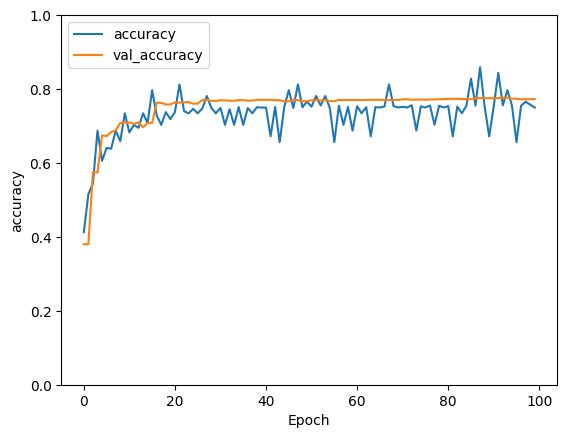

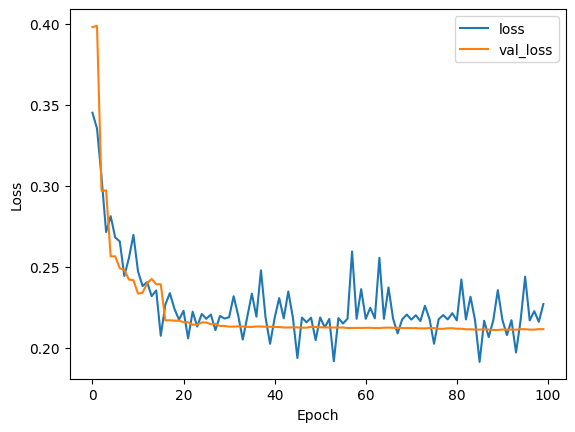

In [12]:
# Plot accuracy graph
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1.0])
plt.legend(loc='upper left')
plt.show()

# Plot loss graph
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0, 3.5])
plt.legend(loc='upper right')
plt.show()

In [15]:
# save_model_and_weights(model, test_acc):
# Serialize and save model to JSON
test_acc = int(test_acc * 10000)
model_json = model.to_json()
with open('models/model' + str(test_acc) + '.json', 'w+') as json_file:
    json_file.write(model_json)
# Serialize and save weights to JSON
model.save_weights('models/fer.weights.h5')
print('Model and weights are saved in separate files.')

Model and weights are saved in separate files.
